In [29]:
import sqlite3
import pandas as pd
import filler
import trainer
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Check data quality

def identify_data_issues(df):
    """
    Identify duplicated timestamps, missing intervals, and 
    out-of-order rows in a time-indexed DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing a 'Time' column.
        
    Returns:
        duplicates (pd.DataFrame): Rows that contain duplicate timestamps.
        missing_intervals (pd.DatetimeIndex): Start points of intervals where data is missing.
        is_unordered (bool): True if the data is not strictly time-ordered.
    """
    # Ensure 'Time' is a datetime column
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    
    # Check for any NaT (Not a Time) conversions which indicate invalid timestamps
    if df['Time'].isnull().any():
        raise ValueError("Some timestamps could not be converted to datetime.")
    
    # Check if the data is ordered by 'Time'. If not, sort it.
    if not df['Time'].is_monotonic_increasing:
        is_unordered = True
        df = df.sort_values('Time').reset_index(drop=True)
    else:
        is_unordered = False
    
    # Identify duplicates
    duplicates = df[df.duplicated(subset='Time', keep=False)]

    # Identify missing intervals
    # Calculate the difference between consecutive rows
    time_diffs = df['Time'].diff().dropna()
    # Any gap larger than 1 minute indicates missing intervals
    missing_intervals = time_diffs[time_diffs > pd.Timedelta('1min')]

    return duplicates, missing_intervals, is_unordered

# Example usage:
df = filler.read_data_from_table("ethusd")  # Assuming you have a function that reads from SQLite
duplicates, missing_intervals, is_unordered = identify_data_issues(df)
print("Duplicates:\n", duplicates)
print("Missing intervals:\n", missing_intervals)
print("Data is unordered:", is_unordered)


# Run trainer

from trainer import train_model

# Custom hyperparameters
custom_hyperparameters = {
    "n_estimators": 200,
    "max_depth": 3,
    "learning_rate": 0.1,
    "min_child_weight": 5,
    "colsample_bytree": 0.5,
    "tree_method": 'hist',
}

train_model(hyperparameters=custom_hyperparameters)

In [30]:
# from predictor import predict_range

# predict_range("2024-12-10 05:18:00", "2025-01-12 22:54:00")

# Load range predictions

In [31]:
# Define database connection function
def connect_to_sqlite():
    conn = sqlite3.connect("crypto_data.sqlite", check_same_thread=False)
    conn.execute("PRAGMA journal_mode=WAL;")  # Enable concurrent reads and writes
    return conn

def load_preds():
    conn = connect_to_sqlite()
    query = """
        SELECT * 
        FROM prediction_seq
        WHERE timestamp > '2025-01-08 14:30:00'
        ORDER BY timestamp DESC 
        """
    df = pd.read_sql_query(query, conn)  # Read the data into a pandas DataFrame
    conn.close()
    return df.sort_values('timestamp')

preds = load_preds()
# Remove duplicate rows from the DataFrame
preds = preds.drop_duplicates()
preds

,timestamp,current_close_price,predicted_next_absolute_max,predicted_percentage_change
24354,2025-01-08 14:31:00,3349.11,3336.259766,-0.383691
24353,2025-01-08 14:32:00,3357.73,3343.743408,-0.416549
24352,2025-01-08 14:33:00,3365.32,3343.437012,-0.650250
24351,2025-01-08 14:34:00,3371.75,3354.920654,-0.499128
24350,2025-01-08 14:35:00,3378.22,3357.273682,-0.620040
...,...,...,...,...
6,2025-01-29 15:02:00,3103.84,3106.748291,0.093700
4,2025-01-29 15:03:00,3104.01,3108.226807,0.135850
3,2025-01-29 15:04:00,3104.69,3111.580078,0.221925
2,2025-01-29 15:05:00,3103.96,3107.931396,0.127946


## Projection chart

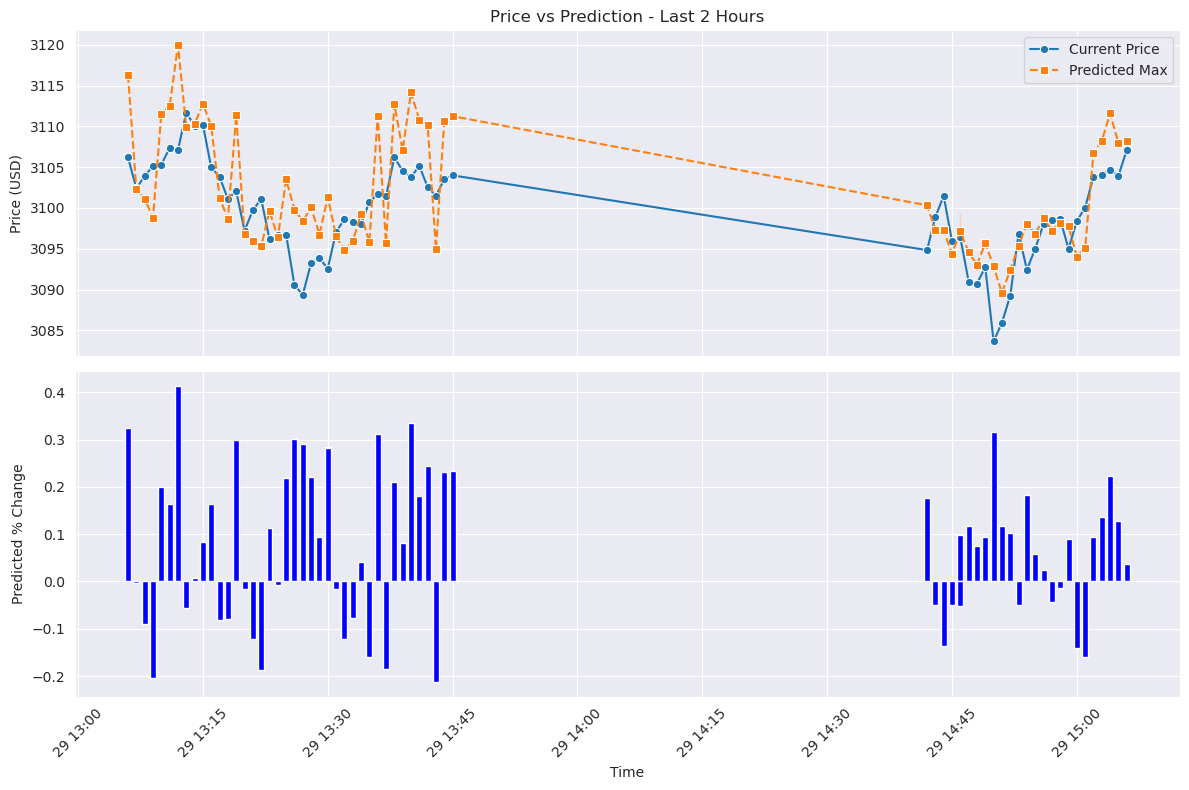

In [32]:
# Convert timestamp to datetime
preds['timestamp'] = pd.to_datetime(preds['timestamp'])

# Filter for the last N hours
hours = 2
cutoff_time = preds['timestamp'].max() - timedelta(hours=hours)
df_filtered = preds[preds['timestamp'] >= cutoff_time]

# Create subplots: 2 rows, 1 column, sharing the same X-axis
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))
sns.set_style("darkgrid")

# --- TOP SUBPLOT (line chart) ---
sns.lineplot(
    data=df_filtered,
    x='timestamp',
    y='current_close_price',
    label='Current Price',
    marker='o',
    ax=ax1
)

sns.lineplot(
    data=df_filtered,
    x='timestamp',
    y='predicted_next_absolute_max',
    label='Predicted Max',
    marker='s',
    linestyle='--',
    ax=ax1
)

ax1.set_title(f'Price vs Prediction - Last {hours:.0f} Hours')
ax1.set_ylabel('Price (USD)')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# --- BOTTOM SUBPLOT (bar chart using matplotlib) ---
# Plot bars for predicted_percentage_change
ax2.bar(
    df_filtered['timestamp'], 
    df_filtered['predicted_percentage_change'], 
    width=0.0005,   # Adjust this width for visibility; 
                    # the value is in "days" if `timestamp` is a datetime
    color='blue'
)

ax2.set_ylabel('Predicted % Change')
ax2.set_xlabel('Time')
ax2.tick_params(axis='x', rotation=45)

# Format the date on the shared X-axis
# ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
# ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax2.xaxis.get_major_locator()))

plt.tight_layout()
plt.show()

In [33]:
# from predictor import predict_latest_price

# predict_latest_price()